<>:53: SyntaxWarning: invalid escape sequence '\$'
<>:53: SyntaxWarning: invalid escape sequence '\$'
/var/folders/gj/n6dwtv650h79sxt750cq8mp00000gn/T/ipykernel_54416/2154023585.py:53: SyntaxWarning: invalid escape sequence '\$'
  ax.set_ylabel(f"Profit/Loss per Contract (\${contract_multiplier}/pt)", fontsize=9)


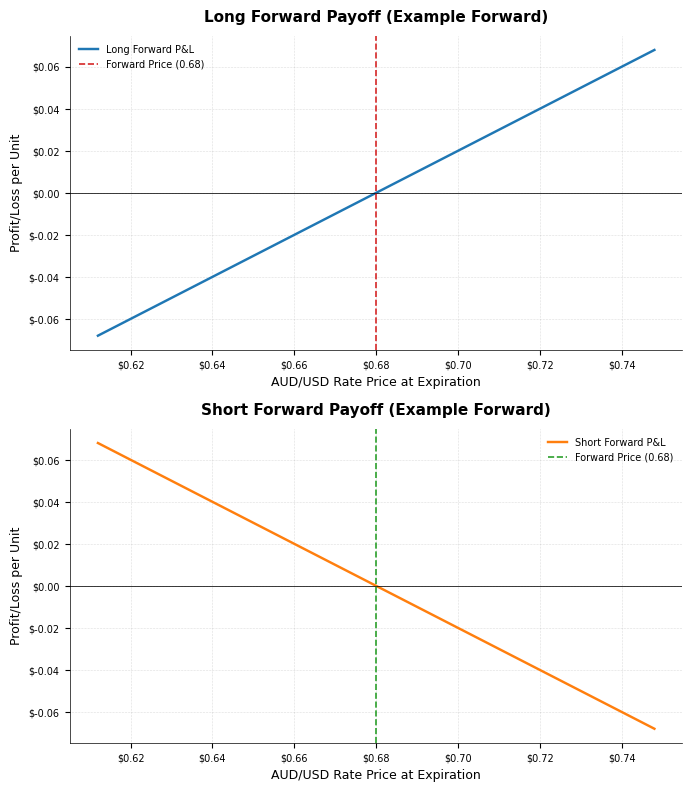

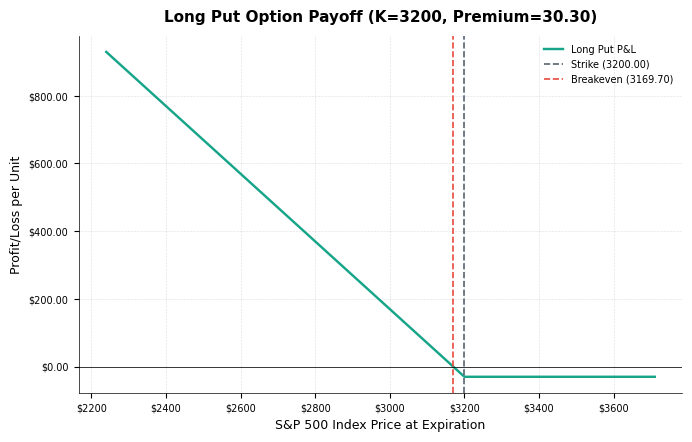

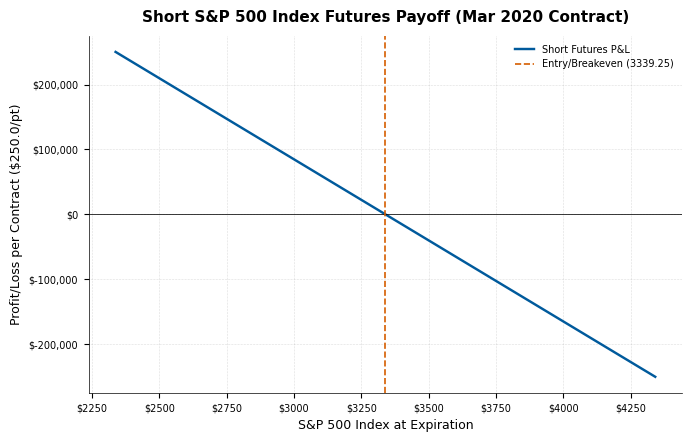

In [1]:
import warnings
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns
import os
import yfinance as yf
from scipy import stats
from scipy.stats import norm, lognorm, t
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def plot_long_put_payoff(ax, spot_range, strike_price, premium, underlying_name="S&P 500", option_details=""):
    payoff = np.maximum(strike_price - spot_range, 0) - premium
    breakeven_point = strike_price - premium

    ax.plot(spot_range, payoff, color='#17A589', linewidth=1.75, label='Long Put P&L')
    ax.axhline(0, color='black', linewidth=0.6, linestyle='-', alpha=0.9)
    ax.axvline(strike_price, color='#566573', linestyle='--', linewidth=1.2, label=f'Strike ({strike_price:.2f})')
    ax.axvline(breakeven_point, color='#E74C3C', linestyle='--', linewidth=1.2, label=f'Breakeven ({breakeven_point:.2f})')

    ax.set_xlabel(f"{underlying_name} Price at Expiration", fontsize=9)
    ax.set_ylabel("Profit/Loss per Unit", fontsize=9)
    ax.set_title(f"Long Put Option Payoff{option_details}", fontsize=11, weight='bold', pad=10)

    ax.legend(fontsize=7, loc='upper right', frameon=False)
    ax.grid(True, linestyle=':', linewidth=0.4, alpha=0.5, color='grey')

    ax.tick_params(axis='both', which='major', labelsize=7, direction='out', pad=4)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('$%.0f'))
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f'${y:,.2f}'))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.set_facecolor('white')

def plot_short_futures_payoff(ax, spot_range, futures_price, contract_multiplier, underlying_name, contract_details=""):
    total_payoff = (futures_price - spot_range) * contract_multiplier

    ax.plot(spot_range, total_payoff, color='#005A9C', linewidth=1.75, label='Short Futures P&L')
    ax.axhline(0, color='black', linewidth=0.6, linestyle='-', alpha=0.9)
    ax.axvline(futures_price, color='#D55E00', linestyle='--', linewidth=1.2, label=f'Entry/Breakeven ({futures_price:.2f})')

    ax.set_xlabel(f"{underlying_name} at Expiration", fontsize=9)
    ax.set_ylabel(f"Profit/Loss per Contract (\${contract_multiplier}/pt)", fontsize=9)
    ax.set_title(f"Short {underlying_name} Futures Payoff{contract_details}", fontsize=11, weight='bold', pad=10)

    ax.legend(fontsize=7, loc='upper right', frameon=False)
    ax.grid(True, linestyle=':', linewidth=0.4, alpha=0.5, color='grey')

    ax.tick_params(axis='both', which='major', labelsize=7, direction='out', pad=4)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('$%.0f'))
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f'${y:,.0f}'))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.set_facecolor('white')

def plot_long_forward_payoff(ax, spot_range, forward_price, contract_size=1, underlying_name="", contract_details=""):
    # Payoff for a long forward is (Spot Price at Expiration - Forward Price) * Contract Size
    payoff = (spot_range - forward_price) * contract_size
    breakeven_point = forward_price # Break-even is when Spot Price at Expiration = Forward Price

    ax.plot(spot_range, payoff, color='#1f77b4', linewidth=1.75, label='Long Forward P&L') # Using a default Plotly blue color
    ax.axhline(0, color='black', linewidth=0.6, linestyle='-', alpha=0.9)
    ax.axvline(forward_price, color='#d62728', linestyle='--', linewidth=1.2, label=f'Forward Price ({forward_price:.2f})') # Using a default Plotly red color

    ax.set_xlabel(f"{underlying_name} Price at Expiration", fontsize=9)
    ax.set_ylabel("Profit/Loss per Unit", fontsize=9)
    ax.set_title(f"Long Forward Payoff{contract_details}", fontsize=11, weight='bold', pad=10)

    ax.legend(fontsize=7, loc='upper left', frameon=False) # Adjusted legend location for forward
    ax.grid(True, linestyle=':', linewidth=0.4, alpha=0.5, color='grey')

    ax.tick_params(axis='both', which='major', labelsize=7, direction='out', pad=4)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('$%.2f')) # Using .2f for prices
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f'${y:,.2f}')) # Using .2f for P&L

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.set_facecolor('white')

def plot_short_forward_payoff(ax, spot_range, forward_price, contract_size=1, underlying_name="", contract_details=""):
    # Payoff for a short forward is (Forward Price - Spot Price at Expiration) * Contract Size
    payoff = (forward_price - spot_range) * contract_size
    breakeven_point = forward_price # Break-even is when Spot Price at Expiration = Forward Price

    ax.plot(spot_range, payoff, color='#ff7f0e', linewidth=1.75, label='Short Forward P&L') # Using a default Plotly orange color
    ax.axhline(0, color='black', linewidth=0.6, linestyle='-', alpha=0.9)
    ax.axvline(forward_price, color='#2ca02c', linestyle='--', linewidth=1.2, label=f'Forward Price ({forward_price:.2f})') # Using a default Plotly green color

    ax.set_xlabel(f"{underlying_name} Price at Expiration", fontsize=9)
    ax.set_ylabel("Profit/Loss per Unit", fontsize=9)
    ax.set_title(f"Short Forward Payoff{contract_details}", fontsize=11, weight='bold', pad=10)

    ax.legend(fontsize=7, loc='upper right', frameon=False) # Adjusted legend location for forward
    ax.grid(True, linestyle=':', linewidth=0.4, alpha=0.5, color='grey')

    ax.tick_params(axis='both', which='major', labelsize=7, direction='out', pad=4)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('$%.2f')) # Using .2f for prices
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f'${y:,.2f}')) # Using .2f for P&L

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.set_facecolor('white')

example_forward_price = 0.68
example_spot_range = np.linspace(example_forward_price * 0.9, example_forward_price * 1.1, 100) # e.g., +/- 10%

fig_fwd, axs_fwd = plt.subplots(2, 1, figsize=(7, 8)) # Plotting long and short in separate subplots

plot_long_forward_payoff(
    ax=axs_fwd[0],
    spot_range=example_spot_range,
    forward_price=example_forward_price,
    underlying_name="AUD/USD Rate",
    contract_details=" (Example Forward)"
)

plot_short_forward_payoff(
    ax=axs_fwd[1],
    spot_range=example_spot_range,
    forward_price=example_forward_price,
    underlying_name="AUD/USD Rate",
    contract_details=" (Example Forward)"
)

plt.tight_layout(pad=1.0)
plt.show()

# Parameters for Long Put Option
put_K = 3200.00
put_P = 30.30
initial_SP500_for_put_range = 3337.75
spot_price_min_put = put_K * 0.70
spot_price_max_put = put_K * 1.15 + put_P
expiration_spot_prices_put = np.linspace(spot_price_min_put, spot_price_max_put, 500)

# Parameters for Short Futures
futures_entry_price = 3339.25
sp500_contract_multiplier = 250.00
initial_SP500_for_futures_range = 3337.75
spot_price_min_futures = futures_entry_price * 0.70
spot_price_max_futures = futures_entry_price * 1.30
expiration_spot_prices_futures = np.linspace(spot_price_min_futures, spot_price_max_futures, 500)

fig_put, ax_put = plt.subplots(figsize=(7, 4.5))
plot_long_put_payoff(
    ax=ax_put,
    spot_range=expiration_spot_prices_put,
    strike_price=put_K,
    premium=put_P,
    underlying_name="S&P 500 Index",
    option_details=f" (K={put_K:.0f}, Premium={put_P:.2f})"
)
fig_put.tight_layout(pad=1.0)
plt.show()


fig_futures, ax_futures = plt.subplots(figsize=(7, 4.5))
plot_short_futures_payoff(
    ax=ax_futures,
    spot_range=expiration_spot_prices_futures,
    futures_price=futures_entry_price,
    contract_multiplier=sp500_contract_multiplier,
    underlying_name="S&P 500 Index",
    contract_details=" (Mar 2020 Contract)"
)
fig_futures.tight_layout(pad=1.0)
plt.show()

In [6]:
def plot_long_FRA_payoff(ax, fixing_rate_range, agreed_rate, notional, tau, currency="$", contract_details=""):
    payoff = notional * tau * (fixing_rate_range - agreed_rate) / (1 + tau * fixing_rate_range)
    breakeven_point = agreed_rate

    ax.plot(fixing_rate_range * 100, payoff, color='#1f77b4', linewidth=1.75, label='Long FRA P&L')
    ax.axhline(0, color='black', linewidth=0.6, linestyle='-', alpha=0.9)
    ax.axvline(agreed_rate * 100, color='#d62728', linestyle='--', linewidth=1.2, label=f'Agreed Rate ({agreed_rate*100:.2f}%)')

    ax.set_xlabel(f"Fixing Rate (%) at Fixing Date", fontsize=9)
    ax.set_ylabel(f"Payoff at Payment Date ({currency})", fontsize=9)
    ax.set_title(f"Long FRA Payoff{contract_details}", fontsize=11, weight='bold', pad=10)

    ax.legend(fontsize=7, loc='upper left', frameon=False)
    ax.grid(True, linestyle=':', linewidth=0.4, alpha=0.5, color='grey')

    ax.tick_params(axis='both', which='major', labelsize=7, direction='out', pad=4)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f'{currency}{y:,.2f}'))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.set_facecolor('white')

def plot_short_FRA_payoff(ax, fixing_rate_range, agreed_rate, notional, tau, currency="$", contract_details=""):
    payoff = notional * tau * (agreed_rate - fixing_rate_range) / (1 + tau * fixing_rate_range)
    breakeven_point = agreed_rate

    ax.plot(fixing_rate_range * 100, payoff, color='#ff7f0e', linewidth=1.75, label='Short FRA P&L')
    ax.axhline(0, color='black', linewidth=0.6, linestyle='-', alpha=0.9)
    ax.axvline(agreed_rate * 100, color='#2ca02c', linestyle='--', linewidth=1.2, label=f'Agreed Rate ({agreed_rate*100:.2f}%)')

    ax.set_xlabel(f"Fixing Rate (%) at Fixing Date", fontsize=9)
    ax.set_ylabel(f"Payoff at Payment Date ({currency})", fontsize=9)
    ax.set_title(f"Short FRA Payoff{contract_details}", fontsize=11, weight='bold', pad=10)

    ax.legend(fontsize=7, loc='upper right', frameon=False)
    ax.grid(True, linestyle=':', linewidth=0.4, alpha=0.5, color='grey')

    ax.tick_params(axis='both', which='major', labelsize=7, direction='out', pad=4)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f'{currency}{y:,.2f}'))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.set_facecolor('white')

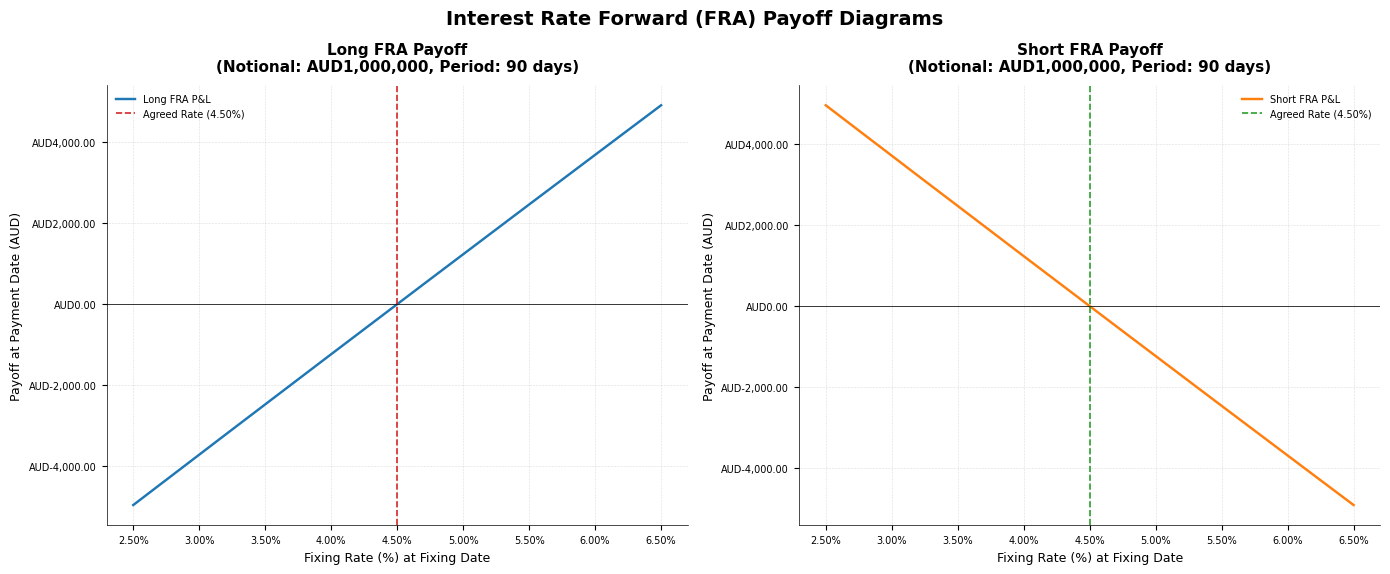

In [7]:
# Define FRA parameters
notional_amount = 1_000_000
agreed_forward_rate = 0.045
accrual_period_tau = 90 / 360
currency_symbol = "AUD"

# Define a range of possible future fixing rates (as decimals)
# Create a range around the agreed rate, ensure rates are non-negative
min_rate = max(0.001, agreed_forward_rate - 0.02)
max_rate = agreed_forward_rate + 0.02
num_points = 200
future_fixing_rate_range_dec = np.linspace(min_rate, max_rate, num_points)


# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Long FRA Payoff
plot_long_FRA_payoff(axes[0], future_fixing_rate_range_dec, agreed_forward_rate, notional_amount, accrual_period_tau, currency=currency_symbol, contract_details=f'\n(Notional: {currency_symbol}{notional_amount:,.0f}, Period: {accrual_period_tau*360:.0f} days)')

# Plot Short FRA Payoff
plot_short_FRA_payoff(axes[1], future_fixing_rate_range_dec, agreed_forward_rate, notional_amount, accrual_period_tau, currency=currency_symbol, contract_details=f'\n(Notional: {currency_symbol}{notional_amount:,.0f}, Period: {accrual_period_tau*360:.0f} days)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Interest Rate Forward (FRA) Payoff Diagrams', fontsize=14, weight='bold')
plt.show()